# Estimating Object Orientation from Velocity 

This notebook is a short proof-of-concept for a Kalman Filter based system to estimate a vehicles orientation only based on its cartesian velocity.

The system is designed to prevent stationary objects from rotating due to slight mis-measurements.

To deal with the problem of choosing an initial orientation, it is proposed to simply pick either "shorter" side of the rectangular object. This notebook shows how the proposed system handles picking the "wrong" side, i.e. the objects back.

Furthermore, fusion of the output with a secondary, more accurate system is shown. Results show that even picking the entirely wrong object direction barely negatively impacts the overall performance after fusion.

Several simplifying assumptions are made throughout the notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.linalg import norm, inv
from numpy import pi
from filterpy.kalman import KalmanFilter
from shapely.geometry import Polygon
RNG = np.random.default_rng(1)

First, define some necessary utility function:

In [2]:
def Rot(alpha):
    """
    Constructs a rotation matrix for given angle alpha.
    """
    r = np.array([
        [np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha), np.cos(alpha)]
    ])
    return r

def draw_car(loc, length, width, alpha, color='g', label='Object', lim=None, mark_center=False, with_arrow=True):
    """
    Draw a "car" of certain size at a given (center) location, oriented according to the angle alpha in radians.
    Color, label are passed to the matplotlib patch.
    lim can be a 2D array, passed to plt.xlim and plt.ylim, or None to disable this.
    mark_center is a bool indicating whether a dot should be added for the object center.
    """
    bottom_left_direction = np.array([-length/2, -width/2])
    bottom_left_direction = Rot(alpha) @ bottom_left_direction
    bottom_left = np.array(loc) + bottom_left_direction
    obj_patch = patches.Rectangle(bottom_left, length, width, np.rad2deg(alpha), fill=False, color=color, label=label, linestyle='--')
    plt.gca().add_patch(obj_patch)
    if with_arrow:
        arrow = Rot(alpha) @ np.array([length/2, 0])
        plt.arrow(*loc, *arrow, width=0.1, length_includes_head=True, color=color)
    if lim is not None:
        plt.xlim(lim)
        plt.ylim(lim)
    if mark_center:
        plt.scatter(*loc, c=color)
        
def car_to_corners(loc, length, width, alpha):
    """
    Given location, length, width and orientation in radians, return four corners of the car.
    """
    loc = np.array(loc)
    corners = [
        [loc+[-length, width]], # "top left"
        [loc+[length, width]],  # "top right"
        [loc+[length, -width]],  # "bottom right"
        [loc+[-length, -width]]  # "bottom left"
    ]
    R = Rot(alpha)
    corners = [R@np.array(c).reshape((2,1)) for c in corners]
    return np.array(corners).reshape((4,2))
        
def iou(car_1, car_2):
    """
    Takes two car representations, each as array, and returns IoU.
    Each 'car' array is an array [loc, length, width, alpha] where loc is again an array of [x,y], the center location.
    """
    box_1 = car_to_corners(*car_1)
    box_2 = car_to_corners(*car_2)
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

## Experiment

In [3]:
loc = np.array([0, 0])  # object center
alpha = pi/2  # true orientation
length = 6  # length of vehicle
width = 2  # width of vehicle

### Settings

The initial orientation is estimated to be towards either shorter side of the vehicle. If this is done randomly, its a 50/50 guess whether the initial estimate is perfect or flipped by 180°.

**Note**: As a simplifying assumption, the box estimate is assumed to perfectly match the original target. No additional noise is added, to simulate an estimate that is slightly off.

`measure_correct_orientation` is the variable that determines whether this initial guess is correct or not. Setting it to `True` means the initial guess is equivalent to the true orientation, setting it to `False` adds an offset of 180°.

In [4]:
measure_correct_orientation = False

# calculate initial alpha for KF
alpha_init = alpha if measure_correct_orientation else alpha+pi

# set initial variance for KF
P_init = 1

### Measurements from stationary object

The stationary object still has a (small) velocity associated with it. These velocity vectors point in more or less arbitrary directions, and change rapidly over time.

After a few steps, the object starts moving in direction of its orientation.

Note that this movement is not reflected in the object center here, the entire simulation is centered around the object.

Overall, 10 velocity measurements are generated: 5 for the stationary object, and 5 in the correct direction with increasing velocity.

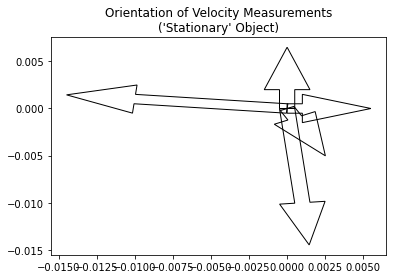

In [5]:
# generate a few velocity measurements, which point in arbitrary directions but are small
velocity_measurements = [
    [-0.01, 0.001],
    [0.001, -0.01],
    [0.001, 0],
    [0.0005, -0.001],
    [0, 0.002]
]

N_MEASUREMENTS_STATIONARY = len(velocity_measurements)
index_last_stationary_measurement = N_MEASUREMENTS_STATIONARY-1  # -1 due to 0 indexing of arrays

for vm in velocity_measurements:
    plt.arrow(0,0,*vm, fill=False)
plt.title("Orientation of Velocity Measurements\n('Stationary' Object)")
plt.show()

# add steps once object is moving
speed = [0.5, 1, 2, 5, 10]
velocity_measurements.extend([Rot(alpha) @ (velo*np.array([1, 0])) for velo in speed])

velocity_measurements = np.around(velocity_measurements, 6)

### Applying a 1D Kalman Filter

Instead of directly taking the orientation estimate based on the velocity measurements, a Kalman Filter will be employed to smooth the estimate.

This is a very simple Kalman Filter with the following settings:
- State and Measurement Space are Identical: Both are $\mathcal{R}$ and represent the orientation of the target object in radians.
- Therefore, the measurement matrix is $\mathbf{H} = \mathbf{I}$ where $\mathbf{I}$ is the 1x1 Identity Matrix
- Similarly, for the motion model: $\mathbf{F} = \mathbf{I}$, as no change in orientation is assumed between time steps.
- No Process Noise is assumed: $\mathbf{Q} = 0$

For the initial values:
- The initial estimate $\hat{x}_{init}$ is provided as described above: based on either "shorter" side of the object
- The initial variance $\mathbf{P}_{init} = 1$

The main idea behind the Filtering approach is to adapt the measurement noise according to the magnitude of the velocity vector:
- Let $v \in \mathcal{R}^2$ be the cartesian velocity estimate of the current time step
- Then $z \in \mathcal{R}$ is the corresponding measurement passed to the Kalman Filter, where $z = atan2(v)$
- The update is done with Measurement noise $\mathbf{R} = \frac{1}{|v|}$

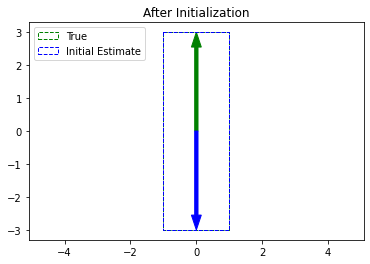

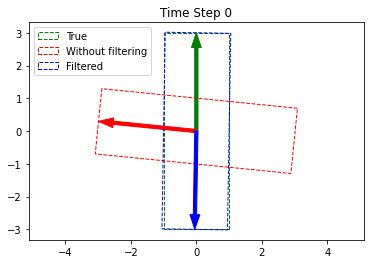

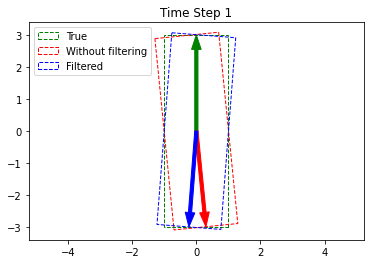

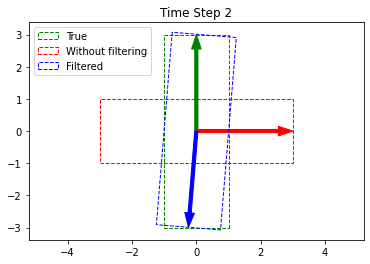

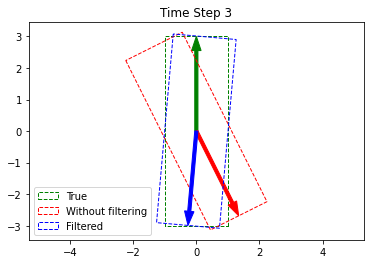

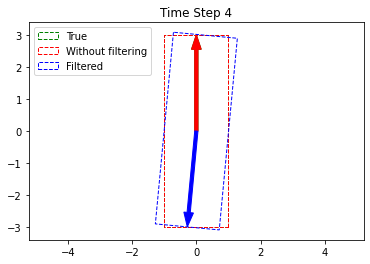

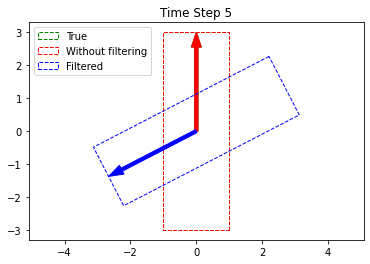

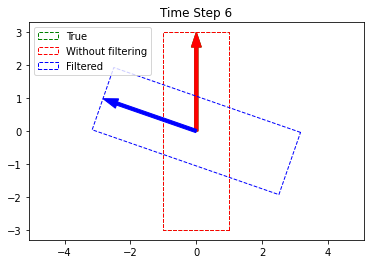

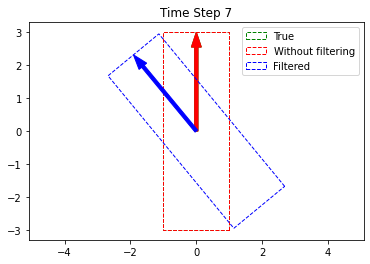

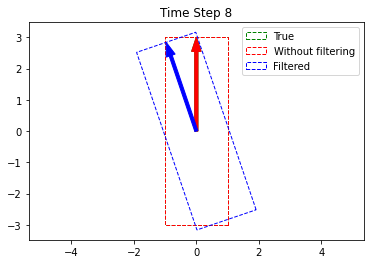

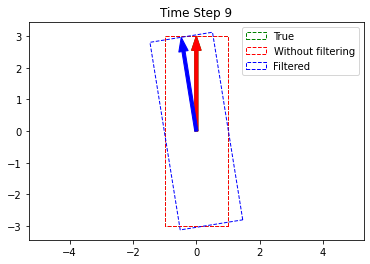

In [6]:
kf = KalmanFilter(dim_x=1, dim_z=1)
kf.Q = 0  # no process noise
kf.H = np.eye(1)  # measurement directly translates to state
kf.x = alpha_init
kf.P = P_init

# pass them to KF sequentially:
draw_car(loc, length, width, alpha, color='g', label='True')
draw_car(loc, length, width, kf.x, color='b', label='Initial Estimate')
plt.legend()
plt.title("After Initialization")
plt.axis('equal')
plt.show()

P_history = []
x_history = []
for ix, vm in enumerate(velocity_measurements):
    # "get measurement"
    alpha_measured = np.arctan2(*vm[::-1])  # invert order so its passed as y,x to atan2
        
    # pass to KF:
    kf.predict()
    vector_norm = norm(vm)
    r = 1/vector_norm
    kf.R = r  # pass to KF
    kf.update(alpha_measured) # update KF
    alpha_filtered = kf.x.flatten()[0]  # extract result
    x_history.append(alpha_filtered)
    P = kf.P.flatten()[0]
    P_history.append(P)
    # show results:
    draw_car(loc, length, width, alpha, color='g', label='True')
    draw_car(loc, length, width, alpha_measured, color='r', label='Without filtering')
    draw_car(loc, length, width, alpha_filtered, color='b', label='Filtered')
    plt.legend()
    plt.title("Time Step {}".format(ix))
    plt.axis('equal')
    plt.show()

## Analysis of Results

### Analysis of IoU Error:

*Note*: The text of this analysis focuses on the problematic case where the initial orientation was guessed incorrectly. If the initial guess is correct, the orientation estimate will be highly accurate throughout all time steps. 

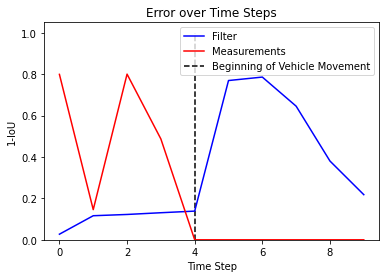

In [7]:
# IoU
car_gt = [loc, length, width, alpha]
error_filter = []
error_measurements = []
for i in range(len(x_history)):
    # get two "car" representations
    car_filter = [loc, length, width, x_history[i]]
    car_measured = [loc, length, width, np.arctan2(*velocity_measurements[i][::-1])]
    # calculate 1-IoU
    error_filter.append(1-iou(car_gt, car_filter))
    error_measurements.append(1-iou(car_gt, car_measured))
    
# plot:
plt.plot(error_filter, c='b', label='Filter')
plt.plot(error_measurements, c='r', label='Measurements')
plt.vlines(index_last_stationary_measurement, ymin=0, ymax=1, color='k', linestyle='--', label='Beginning of Vehicle Movement')
plt.xlabel("Time Step")
plt.ylabel("1-IoU")
plt.ylim(ymin=0)
plt.title("Error over Time Steps")
plt.legend()
plt.show()

If the initial estimate was incorrect by 180°, the IoU is still rather good, until the vehicle starts moving. As expected, the error goes up while the vehicle needs to be "turned around", but as more measurements come in, the estimate and ground truth start overlapping again, and the error goes down again.

For entirely stationary vehicles, this method shows promising improvements of simply using the measurements.

Note that the Error for the non-filtered pure measurements (red) is completely arbitrary since the measurements here are hardcoded.

----
### Analysis of Variance
Additionally, let's take a look at the variance of the box estimate over time steps.

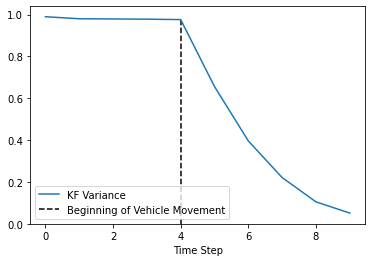

In [8]:
plt.plot(P_history, label='KF Variance')
plt.vlines(index_last_stationary_measurement, ymin=0, ymax=P_history[index_last_stationary_measurement], color='k', linestyle='--', label='Beginning of Vehicle Movement')
plt.legend()
plt.xlabel("Time Step")
plt.ylim(ymin=0)
plt.show()

The variance is more or less steady at a 'high' level (close to the initial value) as long as the incoming measurements are stationary.

As soon as the vehicle accelerates, the measurements start reducing the variance of the KF significantly.

This indicates it is a suitable representation of the uncertainty of the orientation estimate.

## Fusion with accurate estimate

Assume a second sensor provides rather accurate measurements of the orientation. Fusing these measurements with the inaccurate measurements of the previously simulated sensor could cause problems, as the measurements are pointing in almost completly opposite directions, and e.g. averaging the two would yield a completely wrong result.

**'Accurate Sensor' Assumptions**:
- highly accurate estimate of location: Simulated by minor zero-mean Gaussian noise (e.g. var=0.01) on the orientation "measurement" in radians.
- known and low variance: Simulated by setting variance of estimate equal to variance of simulated noise

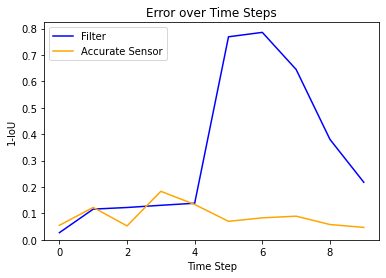

In [9]:
ACCURATE_SENSOR_VARIANCE = 0.01  # variance of simulated accurate sensor

# generate measurements of accurate sensor
accurate_measurements = RNG.normal(loc=alpha, scale=np.sqrt(ACCURATE_SENSOR_VARIANCE), size=len(velocity_measurements))

# calculate accuracy forit
error_accurate_sensor = []
for alpha_hat in accurate_measurements:
    car_sensor = [loc, length, width, alpha_hat]
    error_accurate_sensor.append(1-iou(car_gt, car_sensor))
    
plt.plot(error_filter, c='b', label='Filter')
plt.plot(error_accurate_sensor, c='orange', label='Accurate Sensor')
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("1-IoU")
plt.ylim(ymin=0)
plt.title("Error over Time Steps")
plt.show()

---
For the fusion, we will use the Improved Fast Covariance Intersection Algorithm (I-FCI).

In [10]:
def fusion(x1, P1, x2, P2):
    """
    Very simple implementation of 1D two-argument I-FCI
    using det([a]) = a where [a] is a 1x1 matrix with only value a
    """
    I1 = P1**-1
    I2 = P2**-1
    w = (I1+I2-I2+I1)/2*(I1+I2)
    
    I = w*I1+(1-w)*I2
    x_hat = (I**(-1))*(w*I1*x1+(1-w)*I2*x2)
    return x_hat, I

Apply this function to fuse the filtered and estimated results:

In [11]:
fused_orientations = []
error_fusion = []
for i in range(len(velocity_measurements)):
    # fuse filter and sensor data
    f, var = fusion(x_history[i], P_history[i], accurate_measurements[i], ACCURATE_SENSOR_VARIANCE)
    fused_orientations.append(f)  # save for later use
    # calculate the iou error of the fusion result
    car_fusion = [loc, length, width, f]
    error_fusion.append(1-iou(car_gt, car_fusion))
    

---
Let's take a look at the errors. This time, we will also check out the average error across all time steps, shown as a dashed line.


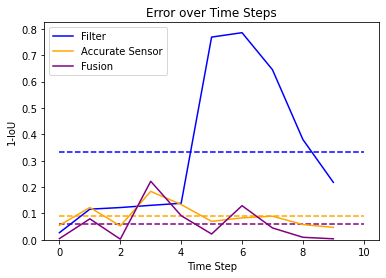

In [12]:
plt.plot(error_filter, c='b', label='Filter')
plt.plot(error_accurate_sensor, c='orange', label='Accurate Sensor')
plt.plot(error_fusion, c='purple', label="Fusion")
# show averages:
plt.hlines(np.average(error_filter), 0, len(error_filter), color='b', linestyle='--')
plt.hlines(np.average(error_accurate_sensor), 0, len(error_accurate_sensor), color='orange', linestyle='--')
plt.hlines(np.average(error_fusion), 0, len(error_fusion), color='purple', linestyle='--')
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("1-IoU")
plt.ylim(ymin=0)
plt.title("Error over Time Steps")
plt.show()

The plot shows that the "bad" filter estimates do not impact the Fusion results negatively: The fusion is actually still an overall improvement over the accurate sensor!

Let's finally take a look at what the fused orientation estimates look like in the world:

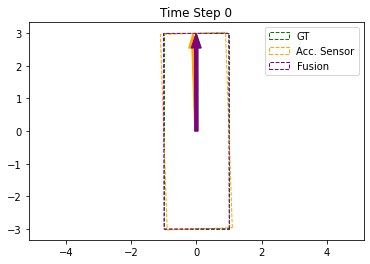

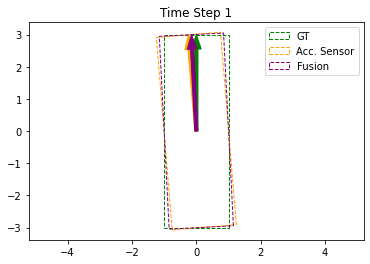

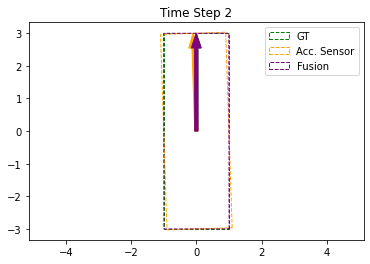

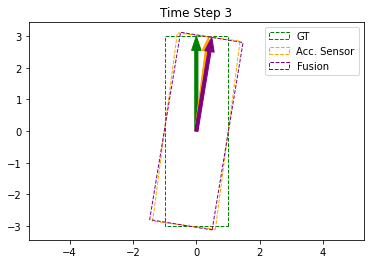

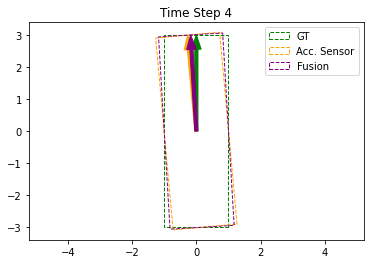

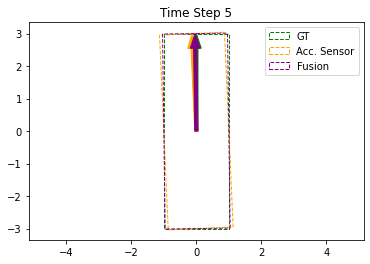

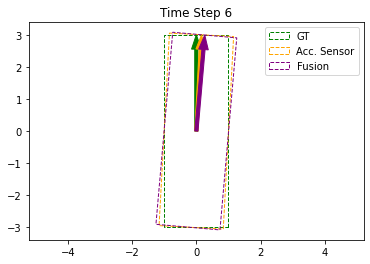

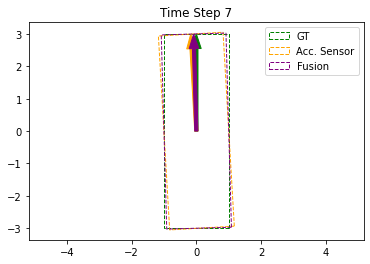

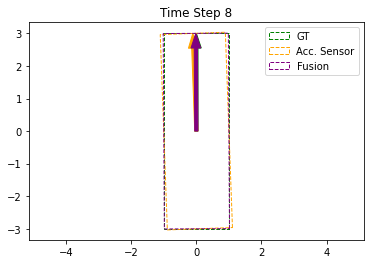

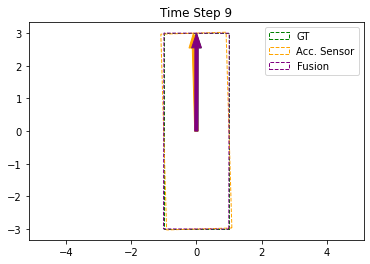

In [13]:
for ix in range(len(x_history)):
    car_fusion = [loc, length, width, fused_orientations[ix]]
    car_sensor = [loc, length, width, accurate_measurements[ix]]
    draw_car(*car_gt, color='g', label='GT')
    draw_car(*car_sensor, color='orange', label='Acc. Sensor')
    draw_car(*car_fusion, color='purple', label='Fusion')
    plt.legend()
    plt.title("Time Step {}".format(ix))
    plt.axis('equal')
    plt.show()

The visualization shows that the fusion almost entirely negates the problems of the Filtering, even if the initial measurement is flipped by 180°.

## A note on real-world application 

First of all, it is important to note that the relation between fusion variance and KF variance plays a large role in the measurement error.

However, I want to point out that the KF variance was initialized with `1`, but this can be scaled to any arbitrary value. The same measurement noise estimation formula can be applied for larger initial variance values, by simply scaling the measurement noise accordingly. This way, it is possible to adapt the KF to whatever variance the "accurate sensor" has in the real world, in order to keep a similar relationship between the variance values.

Additionally, it is probably possible to run two Kalman Filters at the same time, and initialize one with each option for orientation. Then, some kind of heuristic based on the overall change in orientation or a similar metric could be used to determine which one is more likely to be correct. In that case, the slow turn of the object towards the correct orientation would be replaced by a sudden flip in orientation, once the heuristic 'decides' that the alternative Kalman Filter was correct.

Furthemore, I want to emphasize that the Filtering approach relies on the norm of the velocity measurements, and I do not have real-world data to base this on, and therefore do not know what kind of measurements are realistic to expect. However, it is probably possible to adapt to entirely different orders of magnitude of velocity by adapting the initial variance of the Kalman Filter or equivalently by adding a scaling factor to the calculation of the measurement noise.

This notebook is only concerned with a vehicle that is either stationary or moving in a straight line. Further experiments are necessary to determine the impact of the Kalman Filter on the orientation estimate of turning vehicles.